# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 21
### <center> Yoshihiro Shirai

# Generative Adversarial Networks

## 1 Introduction to GANs

- Generative Adversarial Networks (GANs) were introduced by Ian Goodfellow in 2014. It is a generative model, GANs are designed to generate new data samples that resemble a given dataset, such as images, time series, or text. The only other generative model we have seen so far is the Naive Bayes classifier. 

- A GAN consists of two neural network:
    - Generator, which tries to create fake data that looks as realistic as possible;
    - Discriminator, which tries to distinguish between real data (from the training set) and fake data (produced by the generator).

- At each step during training:
    - The generator improves its ability to produce realistic data to fool the discriminator.
    - The discriminator improves its ability to tell real from fake.

- This adversarial process continues until the generator produces data that the discriminator cannot reliably distinguish from real data.

- GANs have become a powerful tool for generative modeling in many fields, including finance, art, and science. It is particularly suitable as a numerical technic for the spectral synthesis problem in Harmonic analysis, i.e. the problem of modifying the decomposition in the trigonometric basis of $L^2$ (or any other basis of any other suitable Banach space) of a signal to generate new ones. The types of signals synthesized may be images, sounds, videos and, of course, time series.



## 2. Training GANs

A Generative Adversarial Network (GAN) consists of two neural networks, a generator $G$ and a discriminator $D$, that are trained simultaneously through adversarial processes.

1. Generator $( G )$
- The generator takes as input a random noise vector $z$ sampled from a prior distribution $p_z(z)$ (often a standard normal distribution).
- It outputs a synthetic data sample $G(z)$ intended to resemble real data.

2. Discriminator $( D )$
- The discriminator receives as input either a real data sample $x \sim \mathbb{P}$ and a fake sample $G(z)$, where $z\sim\mathbb{Q}$.
- Note that $z$ may be a vector of any length $f$, where $f$ is called the receptive field
- It outputs a probability $D(x) \in [0, 1]$ representing the likelihood that $x$ is real.

3. Objective Function
- The GAN training objective is a minimax game between $( G )$ and $( D )$:
$$
\min_G \max_D V(D, G) = \mathbb{E}^{\mathbb{P}} [\log D(x)] + \mathbb{E}^{\mathbb{Q}} [\log(1 - D(G(z)))]
$$
- The higher the value of $V$, the higher the ability of the discrimator, on average, to correctly distinguish between real and fake data
- The lower the value, the higher the ability of the generator, on average, to fool the discriminator

4. Algorithm (Pseudocode)
For each training iteration:
- Sample a minibatch of real data ${x^{(1)}, ..., x^{(m)}}$ from $\mathbb{P}$.
Sample a minibatch of noise ${z^{(1)}, ..., z^{(m)}}$ from $\mathbb{Q}$.
Update the discriminator by stochastic gradient ascent: 
$$
\nabla_{\theta_d} \frac{1}{m} \sum_{i=1}^m [\log D(x^{(i)}) + \log(1 - D(G(z^{(i)})))]
$$
- Sample another minibatch of noise ${z^{(1)}, ..., z^{(m)}}$.
- Update the generator by descending its stochastic gradient: 
$$
[ \nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^m \log(1 - D(G(z^{(i)}))) ]
$$
or (non-saturating loss): 
$$
[ \nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^m -\log D(G(z^{(i)})) ]
$$

5. Summary
- The generator and discriminator are trained in turns.
- The generator learns to produce data that is indistinguishable from real data.
- The discriminator learns to distinguish real from fake data.
- Training continues until the discriminator cannot reliably tell real from fake (i.e., $D(x) \approx 0.5$ for all $x$).

6. References:
Goodfellow, I. et al. (2014). Generative Adversarial Nets ([Arxiv](https://arxiv.org/abs/1412.6515))

## 3. QuantGAN, TAGAN and SAGAN

- The general GAN framework works well for non sequential data, such as image generation

- In finance, of course, one is mainly interested at synthesizing time series 

- Training in this case can be achieved using the time series generative adversarial network (TGAN, [Yoon et al, 2019](https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf)) model

- Here the following model is considered:
    - $\mathbb{P}$ is a uniform distribution over the window data of length $\ell$,so that each sample $x^{(i)}$ of the minibatch is a vector $x_{i:i+\ell-1}$
    - Similarly, each $z^{(i)}$ is now a vector of length $\ell+f$
    - The first $\ell$ elements of $z^{(i)}$ is a batch of real data, while the rest is a normally distributed random vector of size f
    - The generator must be able to take in an arbitrary number $b$ of vectors of length $\ell+f$ and output $b$ vectors of length $\ell$
    - The discriminator must be able to take in an arbitrary number $b$ of vectors of length $\ell$ and output a vector $b$ of probabilities that each input is from the real data

- Of course, we can use different network architecture than standard feedforward networks
    - Convolutional layers have shown effectivness in generating data that resembles locally the statistical features of financial time series (QuantGan, [Wiese et al.](https://arxiv.org/pdf/1907.06673))
    - Self-attention layers are instead suitable to capture long range dependencies of financial time series (TAGAN and SAGAN [Fu et al.](https://arxiv.org/pdf/2207.00493))

## An Example

- We implement the structure above assuming the following structures for the discrimnator and the generator:
    - Discriminator: feedforward network, two hidden layers and one output layer with sigmoid activation
    - Generator: Dense Layer + 2 convolutional layers + 1 Multiheaded attention layer

- The signal is assumed to be composed of a sine and a cosine, with fluctuating frequencies over each window. That is:
    - For each period (here assumed of length `ell`), the phase of sine and cosine are fixed, but randomly selected at the beginning of the period
    - Similarly, the amplituted of the two underlying signals is also random, but fixed throughout the period

- Note: it is advisable at this stage to use GPU for training
    - It is far easier to use GPU with PyTorch, and also more explicit
    - Here I have implemented all the networks in keras
    - There are conflicts between the current version of tensorflow and CUDA
    - So you need to install CUDA 11.8 and cuDNN
    - We also need to scale back to Python 3.10 and use tensorflow 2.10


In [1]:
# Libraries
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Uncomment to force CPU usage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import h5py
import matplotlib.pyplot as plt

# Enable mixed precision if your GPU supports it (RTX 20xx/30xx/40xx or newer)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled.")
except Exception as e:
    print("Mixed precision not enabled:", e)

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("h5py:", h5py.__version__)
print("GPUs available to TensorFlow:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA version:", tf.sysconfig.get_build_info().get("cuda_version"))
print("cuDNN version:", tf.sysconfig.get_build_info().get("cudnn_version"))
!nvcc --version


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9
Mixed precision enabled.
TensorFlow: 2.10.1
NumPy: 1.24.4
h5py: 3.7.0
GPUs available to TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
CUDA version: 64_112
cuDNN version: 64_8
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


We first define the signal.

In [2]:
# Parameters
ell = 50   # Length of each time series sample
f = 20   # Size of the noise vector
T = 10000  # Length of time series
batch_size = 128 # Larger batch size for better GPU utilization
epochs = 1000

# Generate synthetic time series data
# Here we use sine waves as an example
# Generate synthetic time series data: sum of sine, cosine, and Gaussian noise
def generate_real_series(n_samples, ell):
    x = np.linspace(0, 2 * np.pi, ell)
    series = []
    for _ in range(n_samples):
        phase_shift = np.random.uniform(0, 2*np.pi)
        amplitude_sin = np.random.uniform(0.8, 1.2)
        amplitude_cos = np.random.uniform(0.8, 1.2)
        noise = np.random.normal(0, 0.2, ell)
        s = amplitude_sin * np.sin(x + phase_shift) + amplitude_cos * np.cos(2*x + phase_shift) + noise
        series.append(s)
    return np.array(series)

real_series = generate_real_series(T, 2*ell)

def get_real_batch(real_series, batch_size, window_length):
    idx = np.random.randint(0, real_series.shape[0], batch_size)
    batch = real_series[idx, :window_length]  # shape: (batch_size, window_length)
    return batch

Next we define the generator, the discriminator, and the GAN model.

In [3]:
# Generator model
def build_generator(f, ell):
    # Input: (batch_size, f + ell)
    inputs = keras.Input(shape=(f + ell,))
    x = layers.Dense(ell * 16, activation='relu')(inputs)
    x = layers.Reshape((ell, 16))(x)  # (batch_size, ell, 16)
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    # Create a causal mask for self-attention
    # Shape: (1, ell, ell)
    causal_mask = tf.linalg.band_part(tf.ones((ell, ell)), -1, 0)
    causal_mask = tf.cast(causal_mask, dtype=tf.bool)[tf.newaxis, :, :]
    # Self-attention layer
    attn = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x, attention_mask=causal_mask)
    x = layers.Add()([x, attn])  # Residual connection
    x = layers.Flatten()(x)
    outputs = layers.Dense(ell, dtype='float32')(x)  # Output: (batch_size, ell) (in float32 for stability)
    model = keras.Model(inputs, outputs)
    return model

# Discriminator model
def build_discriminator(ell):
    model = keras.Sequential([
        layers.Input(shape=(ell,)),
        layers.Flatten(),  # Flatten the 2D sequence to 1D
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid', dtype='float32'),  # Output: (batch_size, 1) (in float32 for stability)
    ])
    return model

# Build models
generator = build_generator(f, ell)
discriminator = build_discriminator(ell)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# GAN model (generator + frozen discriminator)
discriminator.trainable = False
gan_input = keras.Input(shape=(f+ell,))
gan_output = discriminator(generator(gan_input))
gan = keras.Model(gan_input, gan_output)
gan.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

- Now we train the model. 

- Note that at each step we first train the discriminator for given real and fake batch of data, the last of witch generated by the generator.

- Both the real and the generated data must, however, follow the same previous history of ell observations

- Note: If you are on a CPU, training this model with the above parameters will take far longer. On my cpu (Intel(R) Core(TM) Ultra 9 185H with 22 threads) it takes about 2 minutes and 18 seconds to get to the first epoch, whereas on GPU it takes less than 2 minutes to complete the training.

In [4]:
# Training loop
for epoch in range(epochs):
    # 1. Train discriminator
    discriminator.trainable = True
    batch = get_real_batch(real_series, batch_size,2*ell)
    history_batch = batch[:, :ell]  # shape: (batch_size, ell)
    real_batch = batch[:, ell:2*ell]  # shape: (batch_size, ell)
    noise_batch = np.random.normal(0, 1, (batch_size, f))
    gen_input = np.concatenate([history_batch, noise_batch], axis=1)  # shape: (batch_size, ell+f)
    fake_batch = generator.predict(gen_input, verbose=0)
    X = np.concatenate([real_batch, fake_batch])
    y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    # 2. Train generator (via GAN)
    discriminator.trainable = False
    history_batch = get_real_batch(real_series, batch_size, ell)  # shape: (batch_size, ell)
    noise = np.random.normal(0, 1, (batch_size, f))
    gen_input = np.concatenate([history_batch, noise], axis=1)  # (batch_size, ell+f)
    y_gen = np.ones((batch_size, 1))  # Try to fool the discriminator
    g_metrics = gan.train_on_batch(gen_input, y_gen)
    # Unpack metrics (loss, accuracy)
    if isinstance(g_metrics, list) or isinstance(g_metrics, tuple):
        g_loss = g_metrics[0]
        g_acc = g_metrics[1] if len(g_metrics) > 1 else None
    else:
        g_loss = g_metrics
        g_acc = None
    if epoch % 100 == 0:
        if g_acc is not None:
            print(f"Epoch {epoch}: D loss={d_loss:.4f}, D acc={d_acc:.4f}, G loss={g_loss:.4f}, G acc={g_acc:.4f}")
        else:
            print(f"Epoch {epoch}: D loss={d_loss:.4f}, D acc={d_acc:.4f}, G loss={g_loss:.4f}")


Epoch 0: D loss=0.6582, D acc=0.5742, G loss=0.6771, G acc=1.0000
Epoch 100: D loss=0.7335, D acc=0.6562, G loss=0.8845, G acc=0.0000
Epoch 200: D loss=1.0579, D acc=0.2461, G loss=0.7502, G acc=0.0078
Epoch 300: D loss=0.8300, D acc=0.2305, G loss=0.6044, G acc=1.0000
Epoch 400: D loss=1.5149, D acc=0.5000, G loss=0.9900, G acc=0.0000
Epoch 500: D loss=0.5778, D acc=0.4414, G loss=0.5729, G acc=0.9531
Epoch 600: D loss=0.8234, D acc=0.3203, G loss=0.6157, G acc=0.7500
Epoch 700: D loss=0.5143, D acc=0.7930, G loss=0.9659, G acc=0.0547
Epoch 800: D loss=2.1447, D acc=0.5000, G loss=1.0967, G acc=0.0000
Epoch 900: D loss=0.7872, D acc=0.5977, G loss=0.8483, G acc=0.5234


Finally, we:
- generate a validation batch of data
- compute average discriminator's ability to not be fooled by the generator, and 
- compare generated data for first batch with real data for that batch

Discriminator output on generated data: [0.64086205 0.3703005  0.40004066 0.40841606 0.38740316 0.5025785
 0.5445046  0.594739   0.6026905  0.358935  ]
Mean probability of being real (should be close to 0.5 if fooled): 0.481047


Text(0, 0.5, 'Value')

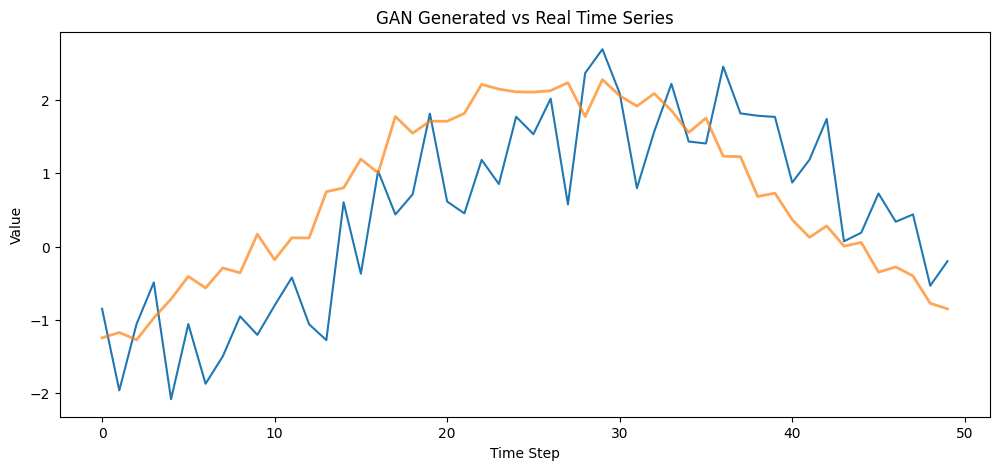

In [6]:
import matplotlib.pyplot as plt

num_windows = 10
window_length = ell

synthetic_series = []
d_pred = []

# Start with random history for the first window
real_series = generate_real_series(num_windows, 2*ell)
history = real_series[:,:ell]  # shape: (ell,)
real_window = real_series[:,ell:2*ell]  # shape: (ell,)

for i in range(num_windows):
    noise = np.random.normal(0, 1, (f,))
    gen_input = np.concatenate([history[i,:], noise])[np.newaxis, :]  # shape (1, ell+f)
    window = generator.predict(gen_input, verbose=0)[0]
    d_pred.append(discriminator.predict(window[np.newaxis, :], verbose=0))
    synthetic_series.append(window)

print("Discriminator output on generated data:", np.array(d_pred).flatten())
print("Mean probability of being real (should be close to 0.5 if fooled):", np.array(d_pred).mean())

plt.figure(figsize=(12, 5))
plt.plot(synthetic_series[0], label="Generated Synthetic Series (Contextual)")
plt.plot(real_window[0,:], label="Real Series", linewidth=2, alpha=0.7)
plt.title("GAN Generated vs Real Time Series")
plt.xlabel("Time Step")
plt.ylabel("Value")